In [1]:
%matplotlib inline

A Survey of the XY Model using Variational Quantum Thermalizer
=====================================================

This demonstration discusses simulates the XY model using technqiues of the Variational Quantum Thermalizer(https://arxiv.org/abs/1910.02071). In the first part of this demonstration we obtain the thermal density matrix for various temperatures by minimizing the cost function of our quantum circuit, and explore the properties of the XY model in the 1 dimensional 4 qubit model, and the two dimensional 9 qubit model. We see that the density matrix obtained by VQT demonstrates the properties of the XY model by plotting the specific heat and magnetization, and finding the critical temperatures by comparing the trace distances between various thermal density matrices. Thus, we find that the VQT produces an adequate thermal matrix that matches the exact solution.
   In the second part of this demonstration we show various properties of the 1 dimensional 4 qubit XY model with a varying external h parameter. First, we show that as expected, the peak of the heat capacity to temperature curve is shifted to the right as h increases. Second, we show when plotting the order parameter-the magnetization in this case-against h, a discontinuous leap occurs, which corresponds to a phase transition.
   In conclusion, the thermal density matrix is a mathematical object from which many properties of the XY model can be derived, and VQT is a method that generates an adequate approximation of such an object.


The Variational Quantum Thermalizer
===============================

The Variational Quantum Thermalizer is a modified VQE algorithm which aims to obtain the mixed thermal state of the Hamiltonian at a certain temperature T. Letting $\beta = \frac{1}{T}$, we can define the thermal density matrix as follows:
$$\rho_\text{thermal} \ = \ \frac{e^{- \hat{H} \beta}}{\text{Tr}(e^{- \hat{H} \beta})} \ = \ \frac{e^{- \hat{H} \beta}}{Z_{\beta}},$$

Since the density matrix is mixed, we must average the $<H>$ for some ansatz over a probability distribution,$p_i(\theta)$  Letting the unitary of our ansatz we $U(\phi)$, where $\phi$ is an adjustable parameter. For our cost function, since the volume of our system is constant, we slightly modify the Helmholtz free energy:
$$F = U-TS$$
$$\beta F = \beta U - S$$

Letting $\mathcal{L}(\phi, \theta) = \beta F$ and, $U = <H>$, we obtain the following for our cost function:

$$\mathcal{L}(\phi, \theta) = \beta\ Tr[U(\phi)\rho_{\theta} U^{\dagger}] - S$$

Here, we define S in terms of $\rho$ according to the von Neumann entropy:
$$ S = -Tr[\rho_{\theta} \log \rho_{\theta}] $$



XY Heisenberg Model
==================
References: https://en.wikipedia.org/wiki/Classical_XY_model

The XY model is a variant of the Heisenberg Model of magnetism, which expands upon the Ising model by allowing for additional degrees of freedom of the spin vectors. The following is the Hamiltonian for the XY model:

$$H = -J\sum_{(i, j)} X_{i} X_{j}  +  Y_{i} Y_{j} -h\sum_{i} Z_{i}$$

For each of the Pauli operators. Here, $J$ is the interaction term between the magnetic dipoles, while $h$ represents the external magnetic field. For our simulation, we examine the cases of the absence and presence of the external magnetic field.

We represent the dipoles as nodes on a graph, with the edges representing their interactions. For two dimensional case, we take the graph to be a grid with periodic boundary conditions, while for the one dimensional case the graph is simply a cycle graph. This is implemented by throught the networkx library. The following 


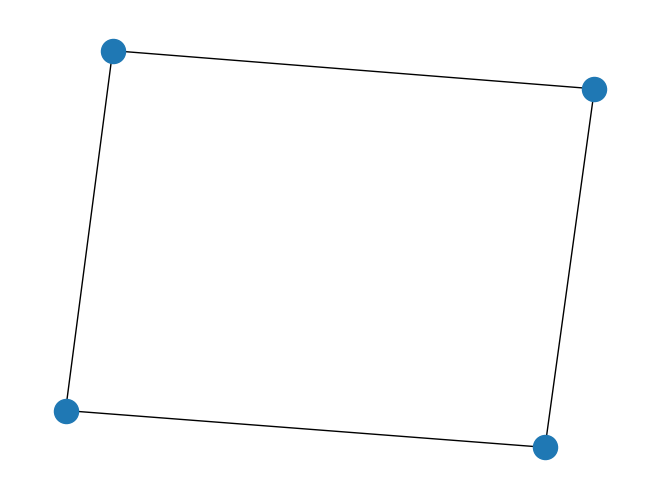

In [6]:
import networkx as nx
interaction_graph = nx.cycle_graph(4)
nx.draw(interaction_graph)

In [ ]:
Fig 1. The one dimensional periodic graph for 4 dipoles(qubits).

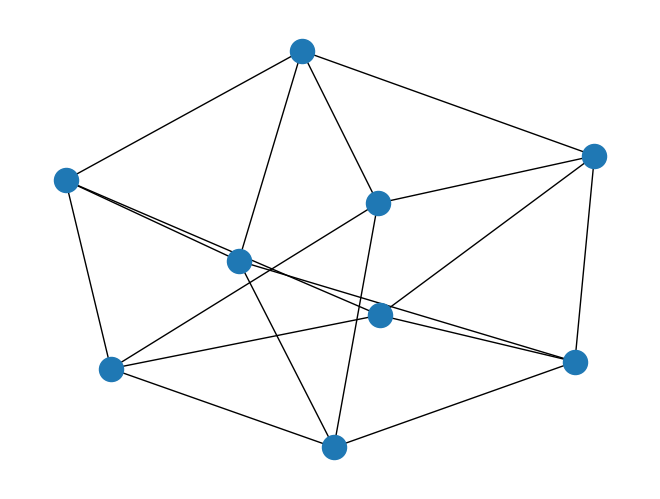

In [12]:
import networkx as nx
interaction_graph = nx.grid_graph((3,3), periodic=True)

nx.draw(interaction_graph)

Fig 2. The two dimensional periodic graph for 9 dipoles(qubits).


Code Implementation
==================
References: https://pennylane.ai/qml/demos/tutorial_vqt.html

The following code follows the procedure for obtaining the thermal density matrix via VQT from the demo "Variational Quantum Thermalizer" by Jack Ceroni(https://pennylane.ai/qml/demos/tutorial_vqt.html)

In [15]:
# Import Modules

import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
import scipy
from scipy.optimize import minimize
import networkx as nx
import itertools
from numpy import savetxt
from numba import jit
import time
import seaborn

In [16]:
# Initial Parameters and Constants
iterations = 0 # Initial Number of iterations 
depth = 4 # Depth of ansatz
nr_qubits = 9 # Number of dipoles(qubits)
h = 1 # External field term
beta_list = [round(1/k,2) for k in range(10,1,-1)]+[k for k in range(1,11)]
T = [1/beta for beta in beta_list]
E = []
C = []
M = []
cost_list = []
rho_list = []

interaction_graph = nx.grid_graph((3,3), periodic=True)
dev = qml.device("default.qubit", wires=nr_qubits)
z_matrix = 1

for i in range (nr_qubits):
    z_matrix = np.kron(z_matrix, qml.matrix(qml.PauliZ(0)))


In [31]:
#Creates the XY Hamiltonian for the case of an external magnetic field
def create_hamiltonian_matrix(n, graph):
    """
    Arguments: 
    n(int): Number of Qubits
    graph(nx.graph): Interaction graph
    
    Returns:
    matrix(np.array): XY Hamiltonian Matrix
    
    """
    
    
    
    
    matrix = np.zeros((2 ** n, 2 ** n))

    for i in graph.edges:
        x = y = 1
        for j in range(0, n):
                       
            if j == i[0] or j == i[1]:
                x = np.kron(x, qml.matrix(qml.PauliX)(0))
                y = np.kron(y, qml.matrix(qml.PauliY)(0))
                
            else:
                x = np.kron(x, np.identity(2))
                y = np.kron(y, np.identity(2))
        
        matrix = np.add(matrix, np.add(x, y))
                
  
    for k in range(n):
        z = 1
        for l in range(k+1):
            if l == k:
                z = np.kron(z, qml.matrix(qml.PauliZ)(0))
            else:
                z = np.kron(z, np.identity(2))
                                
    matrix = np.add(matrix, h*z)
    

    return matrix

In [33]:
# Hamiltonian in the absence of an external magnetic field
def create_hamiltonian_matrix(n, graph):
    matrix = np.zeros((2 ** n, 2 ** n))

    for i in graph.edges:
        x = y = 1
        for j in range(0, n):
                       
            if j == i[0] or j == i[1]:
                x = np.kron(x, qml.matrix(qml.PauliX)(0))
                y = np.kron(y, qml.matrix(qml.PauliY)(0))
                
            else:
                x = np.kron(x, np.identity(2))
                y = np.kron(y, np.identity(2))
        
        matrix = np.add(matrix, np.add(x, y))
                
  
    return matrix

In [15]:
ham_matrix = create_hamiltonian_matrix(nr_qubits, interaction_graph)

In [100]:
# Utility Functions


def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)


def prob_dist(params):
    return np.vstack([sigmoid(params), 1 - sigmoid(params)]).T



def convert_list(params):


    dist_params = params[0:nr_qubits]
    ansatz_params_1 = params[nr_qubits : ((depth + 1) * nr_qubits)]
    ansatz_params_2 = params[((depth + 1) * nr_qubits) :]

    coupling = np.split(ansatz_params_1, depth)


    split = np.split(ansatz_params_2, depth)
    rotation = []
    for s in split:
        rotation.append(np.split(s, 3))

    ansatz_params = [rotation, coupling]

    return [dist_params, ansatz_params]


def calculate_entropy(distribution):
    
    

    total_entropy = 0
    for d in distribution:
        total_entropy += -1 * d[0] * np.log(d[0]) + -1 * d[1] * np.log(d[1])

  

    return total_entropy


def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

In [103]:
# Ansatz Circuit


def single_rotation(phi_params, qubits):

    rotations = ["Z", "Y", "X"]
    for i in range(0, len(rotations)):
        qml.AngleEmbedding(phi_params[i], wires=qubits, rotation=rotations[i])




@qml.qnode(dev)
def quantum_circuit(rotation_params, coupling_params, sample=None):

    
    qml.BasisStatePreparation(sample, wires=range(nr_qubits))


    for i in range(0, depth):
        single_rotation(rotation_params[i], range(nr_qubits))
        qml.broadcast(
            unitary=qml.CRX,
            pattern="ring",
            wires=range(nr_qubits),
            parameters=coupling_params[i]
        )

    
    return qml.expval(qml.Hermitian(ham_matrix, wires=range(nr_qubits)))





In [105]:
# Cost Functions

def exact_cost(params,beta):

    global iterations

   
    parameters = convert_list(params)
    dist_params = parameters[0]
    ansatz_params = parameters[1]
    distribution = prob_dist(dist_params)

    
    combos = itertools.product([0, 1], repeat=nr_qubits)
    s = [list(c) for c in combos]

    
    cost = 0
    for i in s:
        result = quantum_circuit(ansatz_params[0], ansatz_params[1], sample=i)
        for j in range(0, len(i)):
            result *= distribution[j][i[j]]
        cost += result
     

   
    entropy = calculate_entropy(distribution)
    final_cost = beta * cost - entropy

    return final_cost


def cost_execution(params,beta):
    

    global iterations
    

    cost = exact_cost(params,beta)
   
    cost_list.append(cost)
    if iterations % 50 == 0:
        print("Cost at Step {}: {}".format(iterations, cost))

    iterations += 1
    return cost

In [107]:
# Execution Function
@jit(target_backend='cuda', forceobj=True) 	
def execute():
    start = time.time()
    
    for beta in beta_list:
        iterations = 0
        print(f'Starting beta={beta} training')
        number = nr_qubits * (1 + depth * 4)
        params = [np.random.randint(-300, 300) / 100 for i in range(0, number)]
        out = minimize(cost_execution, x0=params, args=(beta),method="COBYLA", options={"maxiter": 100})
        out_params = out["x"]
        prep_density_matrix = prepare_state(out_params, dev)
        savetxt(f'beta_is_{beta}.csv', cost_list, delimiter=',')
        savetxt(f'beta_is_{beta}_params.csv', out_params, delimiter=',')
        params = np.array(np.loadtxt(f'beta_is_{beta}_params.csv', dtype=float))
        cost = exact_cost(params, beta)
       
                
        
        energy = np.trace(np.matmul(prep_density_matrix, ham_matrix))
        magnetization = np.abs(np.trace(np.matmul(prep_density_matrix, z_matrix))) * (1/(nr_qubits-1))**2
        
         
        rho_list.append(prep_density_matrix)
        E.append(energy)
        M.append(magnetization)
        seaborn.heatmap(abs(prep_density_matrix))
        plt.show()
    for beta in beta_list:
        capacitance = np.divide(np.diff(np.array(E)),np.diff(np.array(T)))
        C.append(capacitance)
        
        
    end = time.time()

    print("Total execution time:", (end-start)/60, "m")





In [ ]:
# Plot Values
    
def plot():
    plt.plot(T,E,"bo")
    plt.xlabel('T')
    plt.ylabel('E')

    plt.plot(T,C,"go")
    plt.xlabel('T')
    plt.ylabel('C')

    plt.plot(T,M,"ro")
    plt.xlabel('T')
    plt.ylabel('M')

    plt.show()
    
    

Energy, Heat Capacity, Magnetism Calculations
======================================


Two Dimensional 9 Qubit Case with an external field

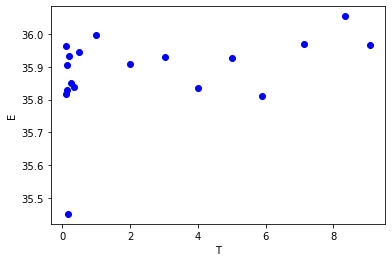

Fig 3. Energy-Temperature plot(Two Dimensional 9 Qubit Case with an external field)

In [51]:
E = [35.966892530908964, 36.05386243437319, 35.97029012973741, 35.81005791576443, 35.925162705420604, 35.834075565887275, 35.9281578693048,
 35.90938816369291, 35.99515817058612, 35.943585240957084, 35.838542110838276, 35.84965046643017, 35.93356123834087, 35.45122336564089, 35.90627837729917, 35.83033529662754,
 35.81778769994885, 35.96413346013405]

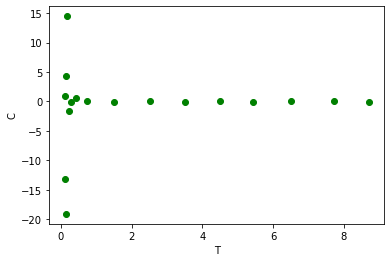

Fig 4. Heat Capacity-Temperature plot(Two Dimensional 9 Qubit Case with an external field)

In [54]:
T = T[:-1]
for beta in beta_list:
        capacitance = np.divide(np.diff(np.array(E)),np.diff(np.array(T)))
        C.append(capacitance)
        
        

[array([ -0.09566689,   0.11031544,   0.13459506,  -0.09131647,
          0.10323209,  -0.0940823 ,   0.01935626,  -0.08324736,
          0.05157293,   0.21008626,  -0.06665013,  -1.00692926,
          9.64675745, -13.65165035,   3.18960939,   0.70266541,
        -10.53689473]),
 array([ -0.09566689,   0.11031544,   0.13459506,  -0.09131647,
          0.10323209,  -0.0940823 ,   0.01935626,  -0.08324736,
          0.05157293,   0.21008626,  -0.06665013,  -1.00692926,
          9.64675745, -13.65165035,   3.18960939,   0.70266541,
        -10.53689473]),
 array([ -0.09566689,   0.11031544,   0.13459506,  -0.09131647,
          0.10323209,  -0.0940823 ,   0.01935626,  -0.08324736,
          0.05157293,   0.21008626,  -0.06665013,  -1.00692926,
          9.64675745, -13.65165035,   3.18960939,   0.70266541,
        -10.53689473]),
 array([ -0.09566689,   0.11031544,   0.13459506,  -0.09131647,
          0.10323209,  -0.0940823 ,   0.01935626,  -0.08324736,
          0.05157293,   0.210086

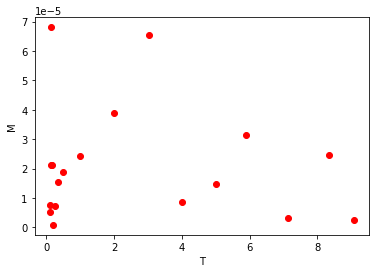

Fig 4. Magnetization-Temperature plot(Two Dimensional 9 Qubit Case with an external field)

In [ ]:
M = [2.60E-06,2.47E-05,3.04E-06,3.15E-05,1.49E-05,8.70E-06,6.54E-05,3.90E-05,2.44E-05,1.87E-05,1.55E-05,7.29E-06,8.49E-07,2.14E-05,6.81E-05,2.12E-05
5.39E-06,7.66E-06]

In [9]:
def create_target(qubit, beta, ham, graph):

    # Calculates the matrix form of the density matrix, by taking
    # the exponential of the Hamiltonian

    h = ham(qubit, graph)
    y = -1 * float(beta) * h
    new_matrix = scipy.linalg.expm(np.array(y))
    norm = np.trace(new_matrix)
    final_target = (1 / norm) * new_matrix

    return final_target


0.1 start 0.11 start 0.12 start 0.14 start 0.17 start 0.2 start 0.25 start 0.33 start 0.5 start 1 start 2 start 3 start 4 start 5 start 6 start 7 start 8 start 9 start 10 start 

Text(0, 0.5, 'E')

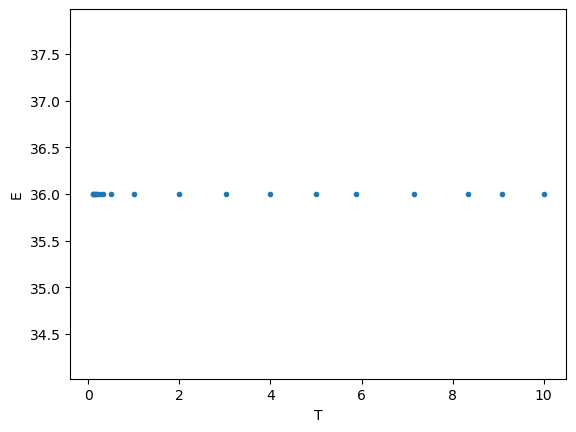

In [35]:
# Comparison to Exact Results

import numpy as np

# Energy

nr_qubits = 9
interaction_graph = nx.grid_graph((3,3), periodic=True)
beta_list = [round(1/k,2) for k in range(10,1,-1)]+[k for k in range(1,11)]
T = [1/beta for beta in beta_list]
beta_list.sort()
exact_energy_list = []
exact_magnetization_list = []
for beta in beta_list:
    target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, interaction_graph)
    hamiltonian = create_hamiltonian_matrix(nr_qubits, interaction_graph)
    exact_energy = np.trace(hamiltonian@target_density_matrix)
    exact_energy_list.append(exact_energy)
    exact_magnetization = np.abs(np.trace(np.matmul(target_density_matrix, z_matrix))) * (1/(nr_qubits-1))**2
    exact_magnetization_list.append(magnetization)
    print(f"{beta} start", end=' ')

plt.plot(T,exact_energy_list,'.')
plt.xlabel('T')
plt.ylabel('E')

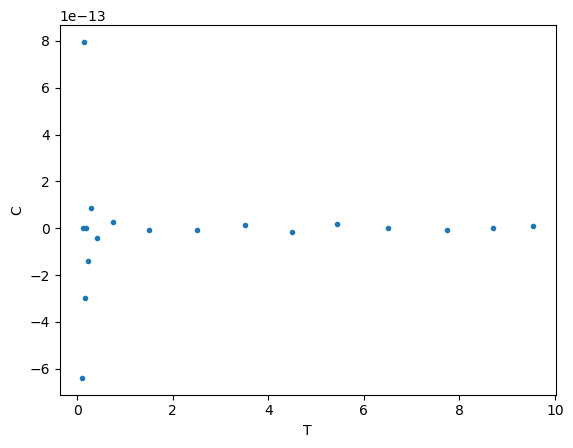

In [37]:
# Heat Capacity

plt.plot((np.array(T)[1:] + T[:-1]) / 2, np.divide(np.diff(np.array(exact_energy_list)),np.diff(np.array(T))),'.')
plt.xlabel('T')
plt.ylabel('C')
plt.show()

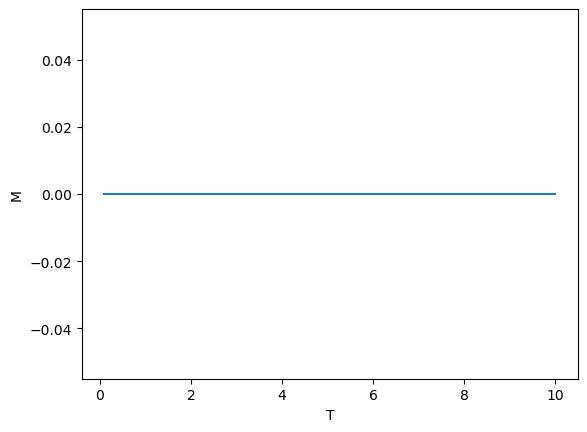

In [38]:
# Magnetism
plt.plot(T, exact_magnetization_list)
plt.xlabel('T')
plt.ylabel('M')
plt.show()



Trace Distance and Critical Temperature
======================================

The trace distance measures how distinguishable two density matrices are by measuring the probability of guessing the density matrix given a certain state. By measuring the trace distance between thermal density matrices of consecutive temperatures, we can determine the extend a state evolves as the temperature changes. By plotting the trace distance against the temperature, we can observe sudden peaks which correspond to the critical temperature. Here the local minima can be seen as the critical temperature points, as the trace distance always increases as the temperature changes at these points.



In [66]:
matrices = []
beta_list = [round(1/k,2) for k in range(10,1,-1)]+[k for k in range(1,11)]
T = [1/beta for beta in beta_list]

# Trace distance

def trace_distance(one, two):

    return 0.5 * np.trace(np.absolute(np.add(one, -1 * two)))

# Generates thermal density matrices
def generate():
    for beta in beta_list:
        target_density_matrix = create_target(nr_qubits, beta, create_hamiltonian_matrix, interaction_graph)
        matrices.append(target_density_matrix)
        

        

# Calculates and plots the given traces against the temperature
    


traces = []   
def plot_traces(T, matrices, traces):
      
    T = T[:-1]
    for i in range(len(matrices)-1):
        traces.append(trace_distance(matrices[i], matrices[i+1]))
    plt.plot(T, traces, 'bo')
    plt.xlabel("Temperature")
    plt.ylabel("Trace Distance")
    plt.show()
    
    traces = np.array(traces)
    np.nan_to_num(traces, copy=False, nan=0.0)
    local_minima = scipy.signal.argrelextrema(traces, np.less)[0]

  


    critical_T = []

    for i in local_minima:
        critical_T.append(T[i])
        
            
        
    print("Critical Temperatures: ", critical_T)
    


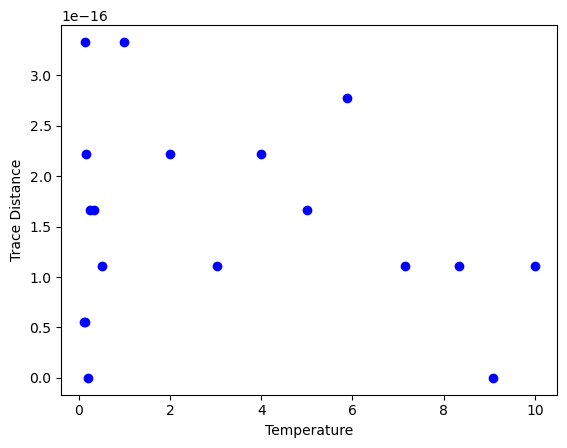

Critical Temperatures:  [9.090909090909092, 5.0, 3.0303030303030303, 0.5, 0.2]


In [67]:
generate()
plot_traces(T, matrices, traces)